In [1]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, train_final_model, plot_confusion_matrices, plot_roc_curves
from model import predict
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing
## Assign labels

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()

np.int64(307)

In [4]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [5]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [6]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [7]:
categorical_unique = preprocessing.unique(df, categorical_columns)

In [8]:
numeric_unique = preprocessing.unique(df, numeric_columns)

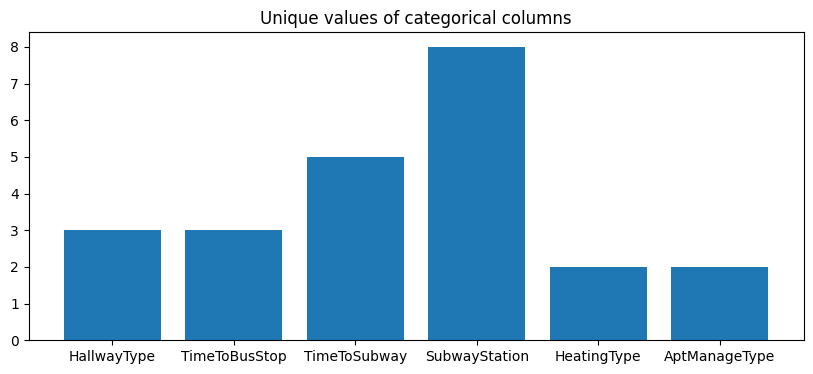

In [9]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [10]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [11]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

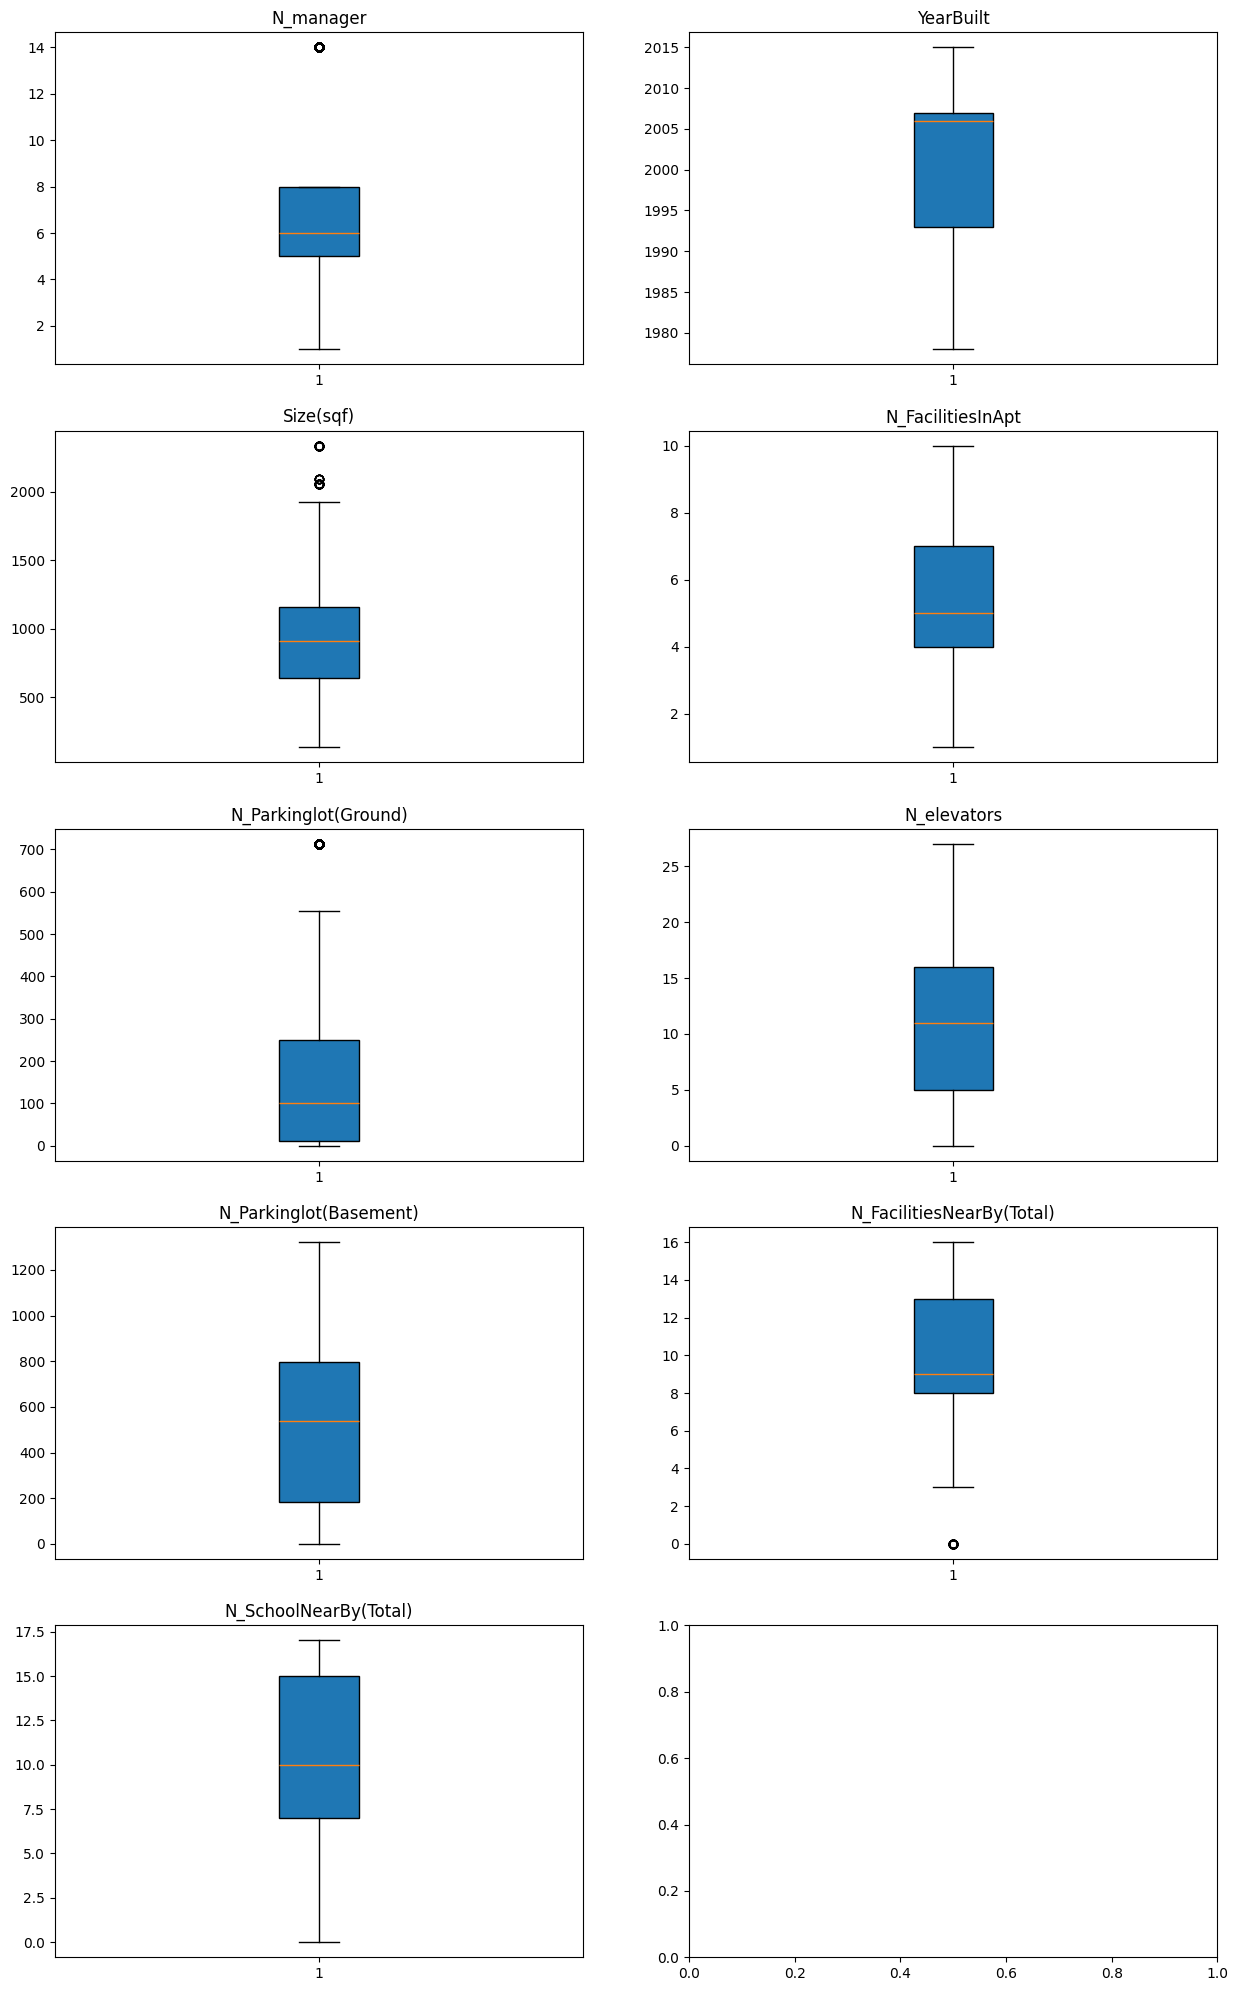

In [12]:
preprocessing.plot_boxplot(df, numeric_columns)

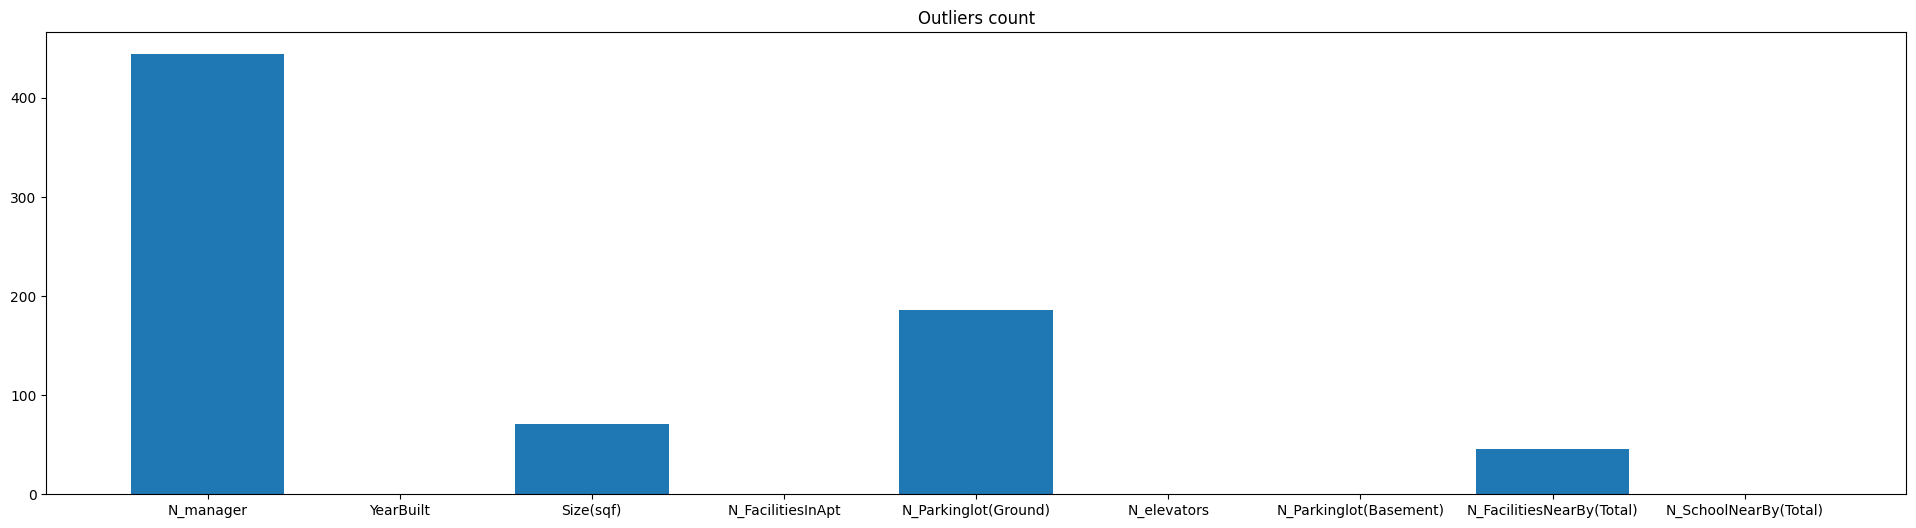

In [13]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

## Analyze if some features have normal distribution

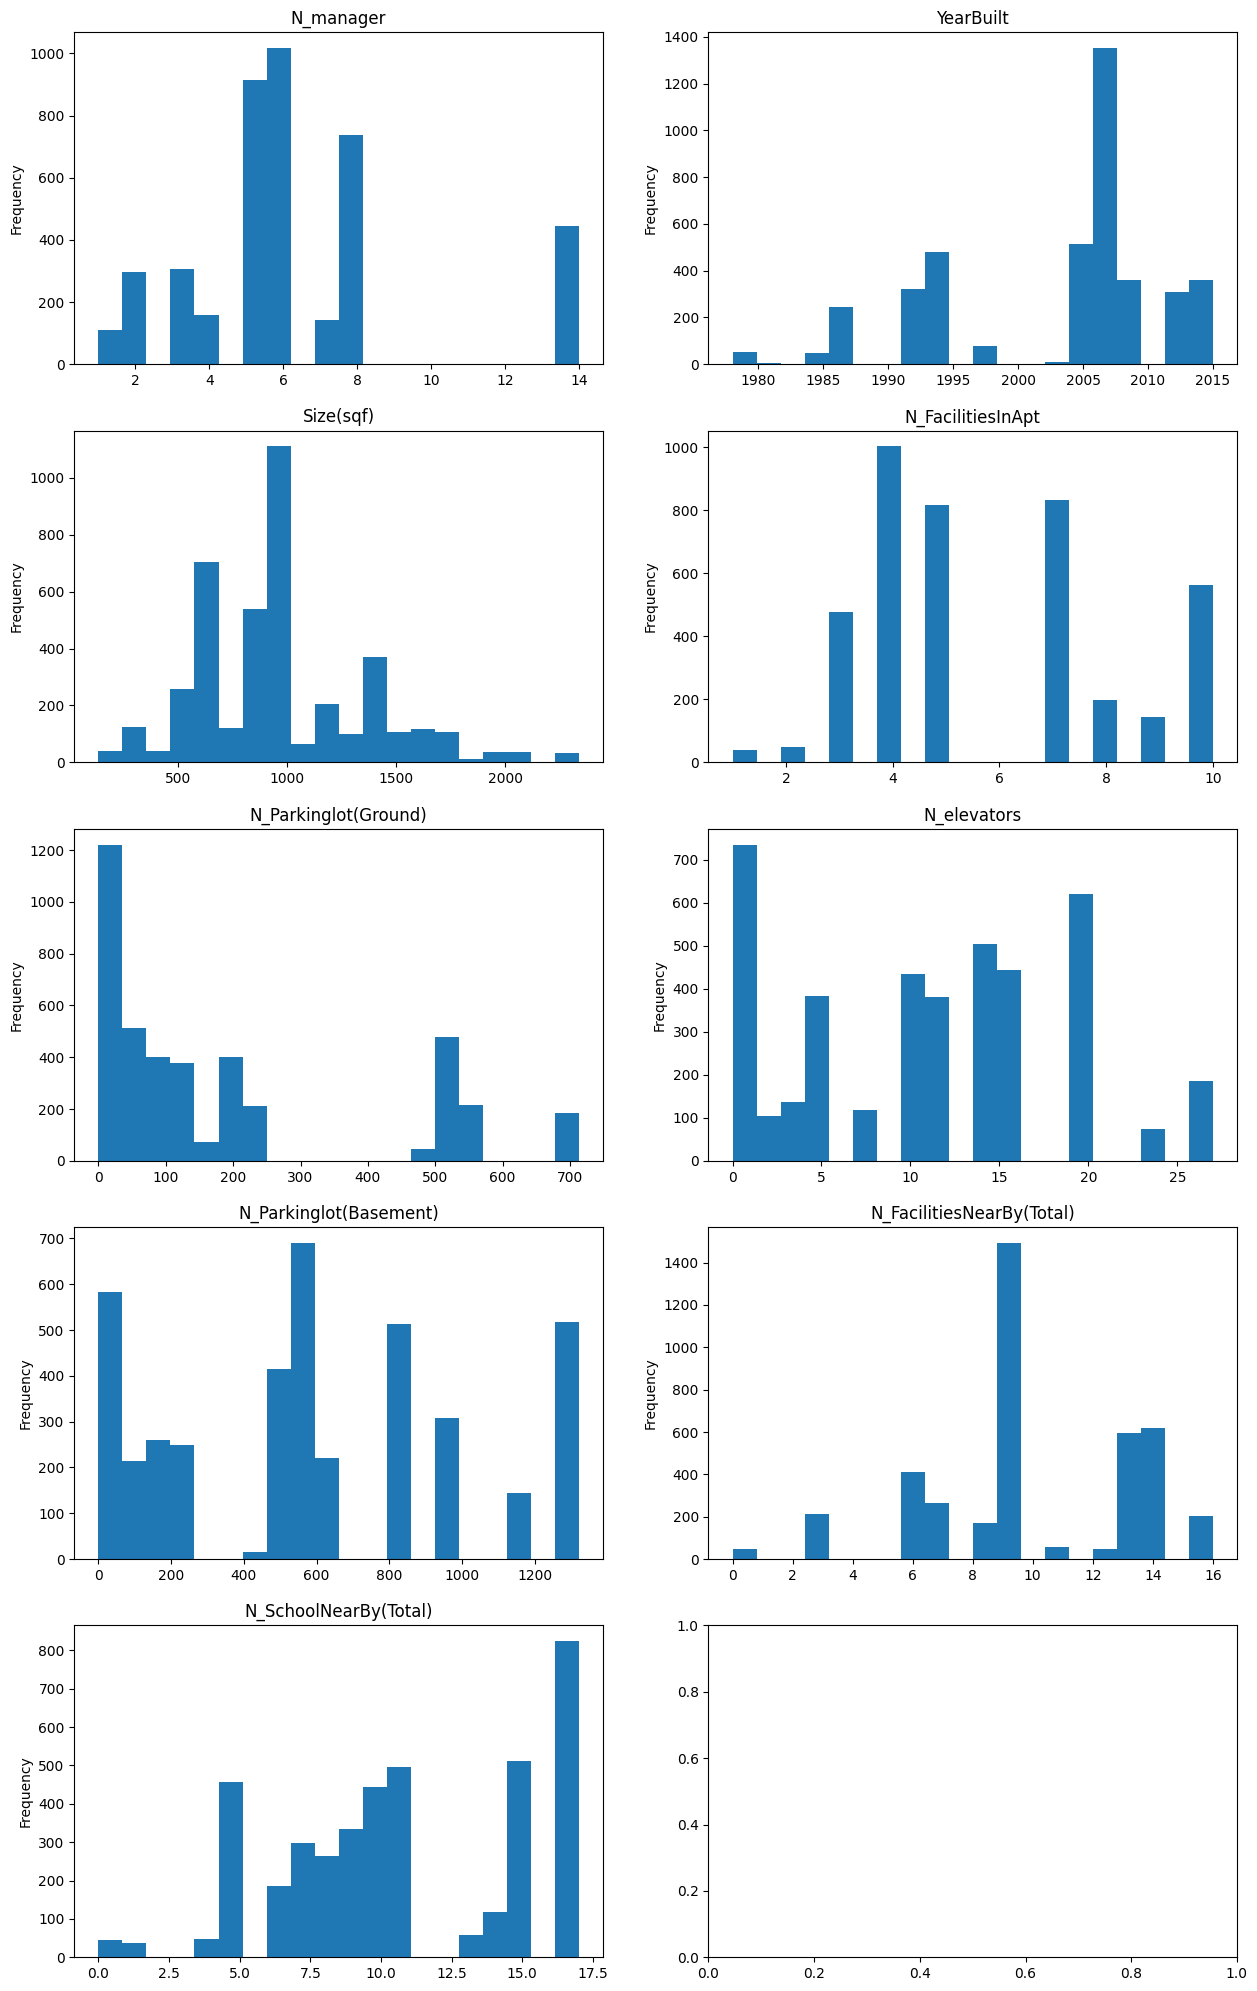

In [14]:
preprocessing.plot_histograms(df, numeric_columns)

In [15]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'N_manager': 'not normally distributed',
 'YearBuilt': 'not normally distributed',
 'Size(sqf)': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed',
 'N_elevators': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed'}

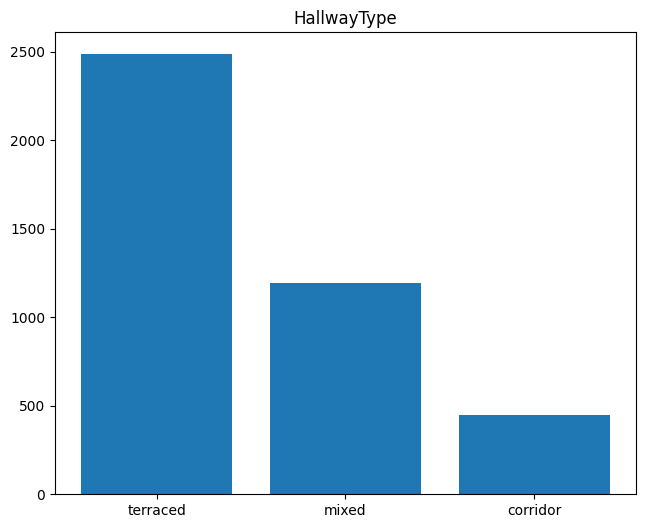

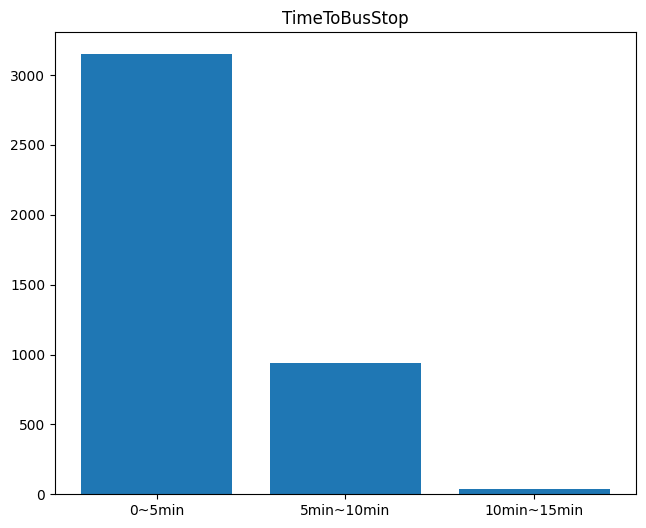

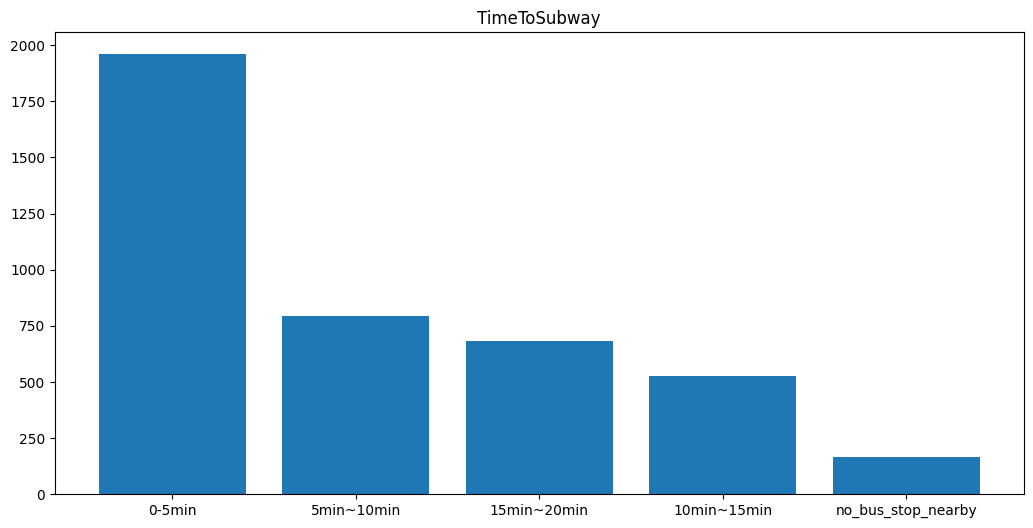

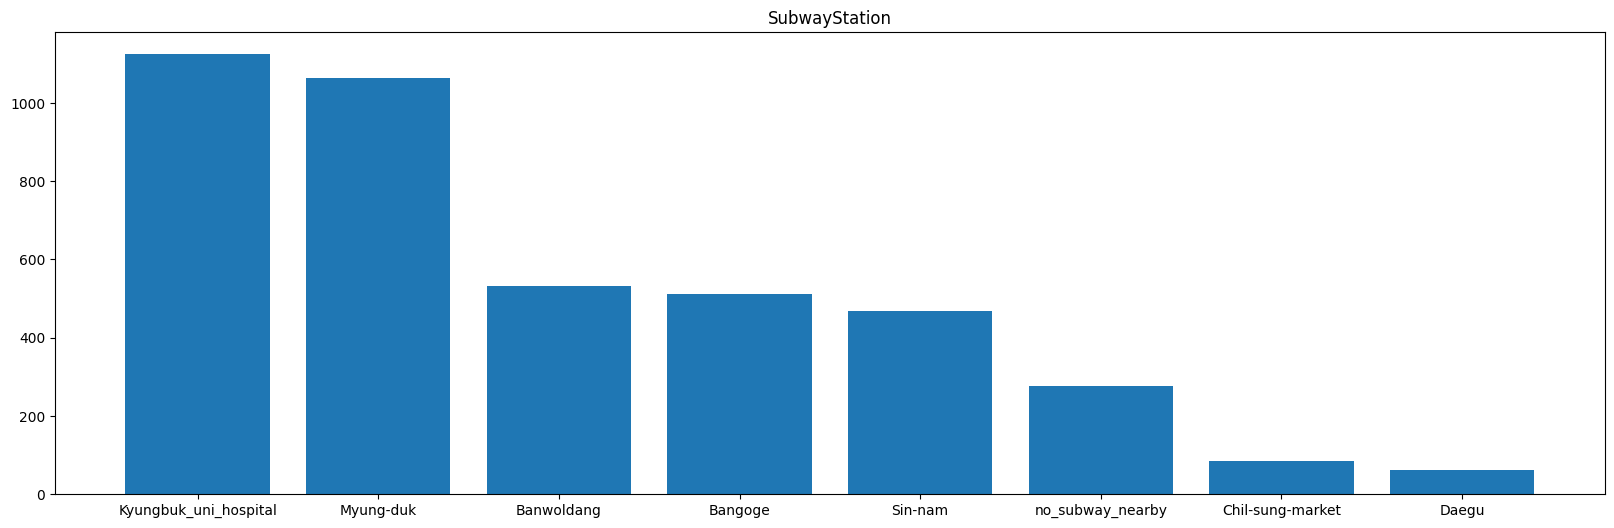

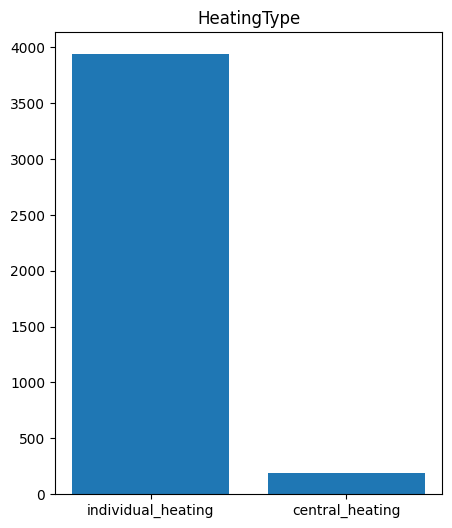

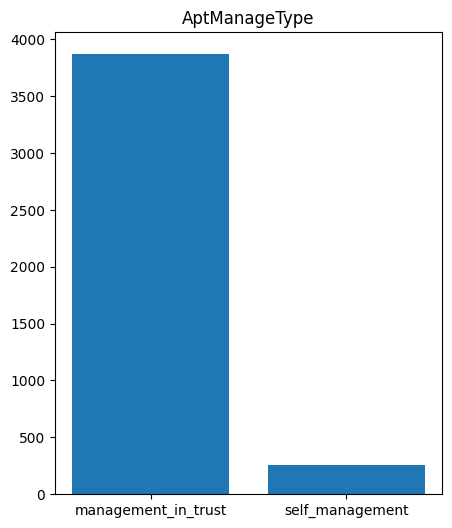

In [16]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

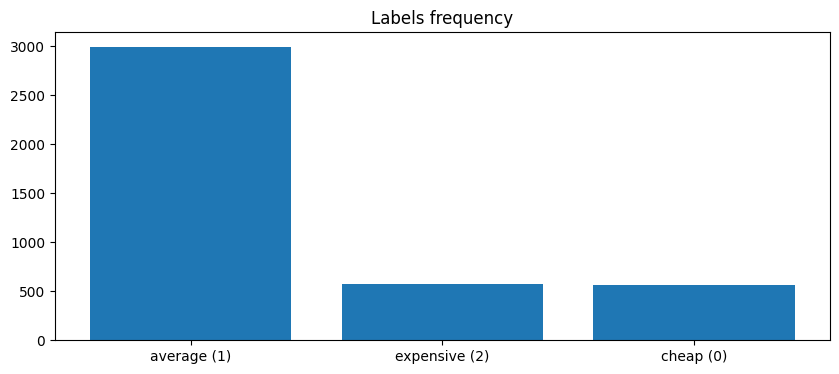

In [17]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

In [18]:
X = df.drop(columns=["Label"])
y = df["Label"]
X, y = preprocessing.preprocess(X, numeric_columns, ordinal_columns, nominal_columns, y=y, oversample=True, undersample=False, random_state=42, echo_ordinal_counts=True)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)

TimeToBusStop value counts:
TimeToBusStop
0~5min         6649
5min~10min     2127
10min~15min     200
Name: count, dtype: int64
ordinal__TimeToBusStop value counts:
ordinal__TimeToBusStop
0.0    6649
1.0    2127
2.0     200
Name: count, dtype: int64
TimeToSubway value counts:
TimeToSubway
0-5min                4160
5min~10min            2064
15min~20min           1349
10min~15min           1238
no_bus_stop_nearby     165
Name: count, dtype: int64
ordinal__TimeToSubway value counts:
ordinal__TimeToSubway
0.0    4160
1.0    2064
3.0    1349
2.0    1238
4.0     165
Name: count, dtype: int64


In [19]:
weights = preprocessing.calculate_class_weights(train_y)
weights

tensor([0.9964, 0.9968, 1.0069])

# Model and training

In [25]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Epoch: 0, loss: 0.8474418431256725
Epoch: 1, loss: 0.5619815392831785
Epoch: 2, loss: 0.4773632583364976
Epoch: 3, loss: 0.43875061648081887
Epoch: 4, loss: 0.4161440719545415
Epoch: 5, loss: 0.3868030242424096
Epoch: 6, loss: 0.37901176894660543
Epoch: 7, loss: 0.36399266308387823
Epoch: 8, loss: 0.35405257159629755
Epoch: 9, loss: 0.3441163798612831
Epoch: 10, loss: 0.3345375448729085
Epoch: 11, loss: 0.33255808451006896
Epoch: 12, loss: 0.3281434357693765
Epoch: 13, loss: 0.32318008539423476
Epoch: 14, loss: 0.3126326178291203
Epoch: 15, loss: 0.31572181487505413
Epoch: 16, loss: 0.31024050198297587
Epoch: 17, loss: 0.30473184466889475
Epoch: 18, loss: 0.3098397273405463
Epoch: 19, loss: 0.3049901334189736
Epoch: 20, loss: 0.3029186725616455
Epoch: 21, loss: 0.3005476330233886
Epoch: 22, loss: 0.3008752999316275
Epoch: 23, loss: 0.2981908699843736
Epoch: 24, loss: 0.297447329733224
Epoch: 25, loss: 0.29608023971055464
Epoch: 26, loss: 0.2955221517291744
Epoch: 27, l

In [26]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.896936,0.896936,0.896936,0.896936,0.896437,0.896437,0.896437,0.896437
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.897075,0.897075,0.897075,0.897075,0.895880,0.895880,0.895880,0.895880
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.898050,0.898050,0.898050,0.898050,0.895880,0.895880,0.895880,0.895880
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.890669,0.890669,0.890669,0.890669,0.890312,0.890312,0.890312,0.890312
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.894011,0.894011,0.894011,0.894011,0.894209,0.894209,0.894209,0.894209
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.895543,0.895543,0.895543,0.895543,0.894209,0.894209,0.894209,0.894209


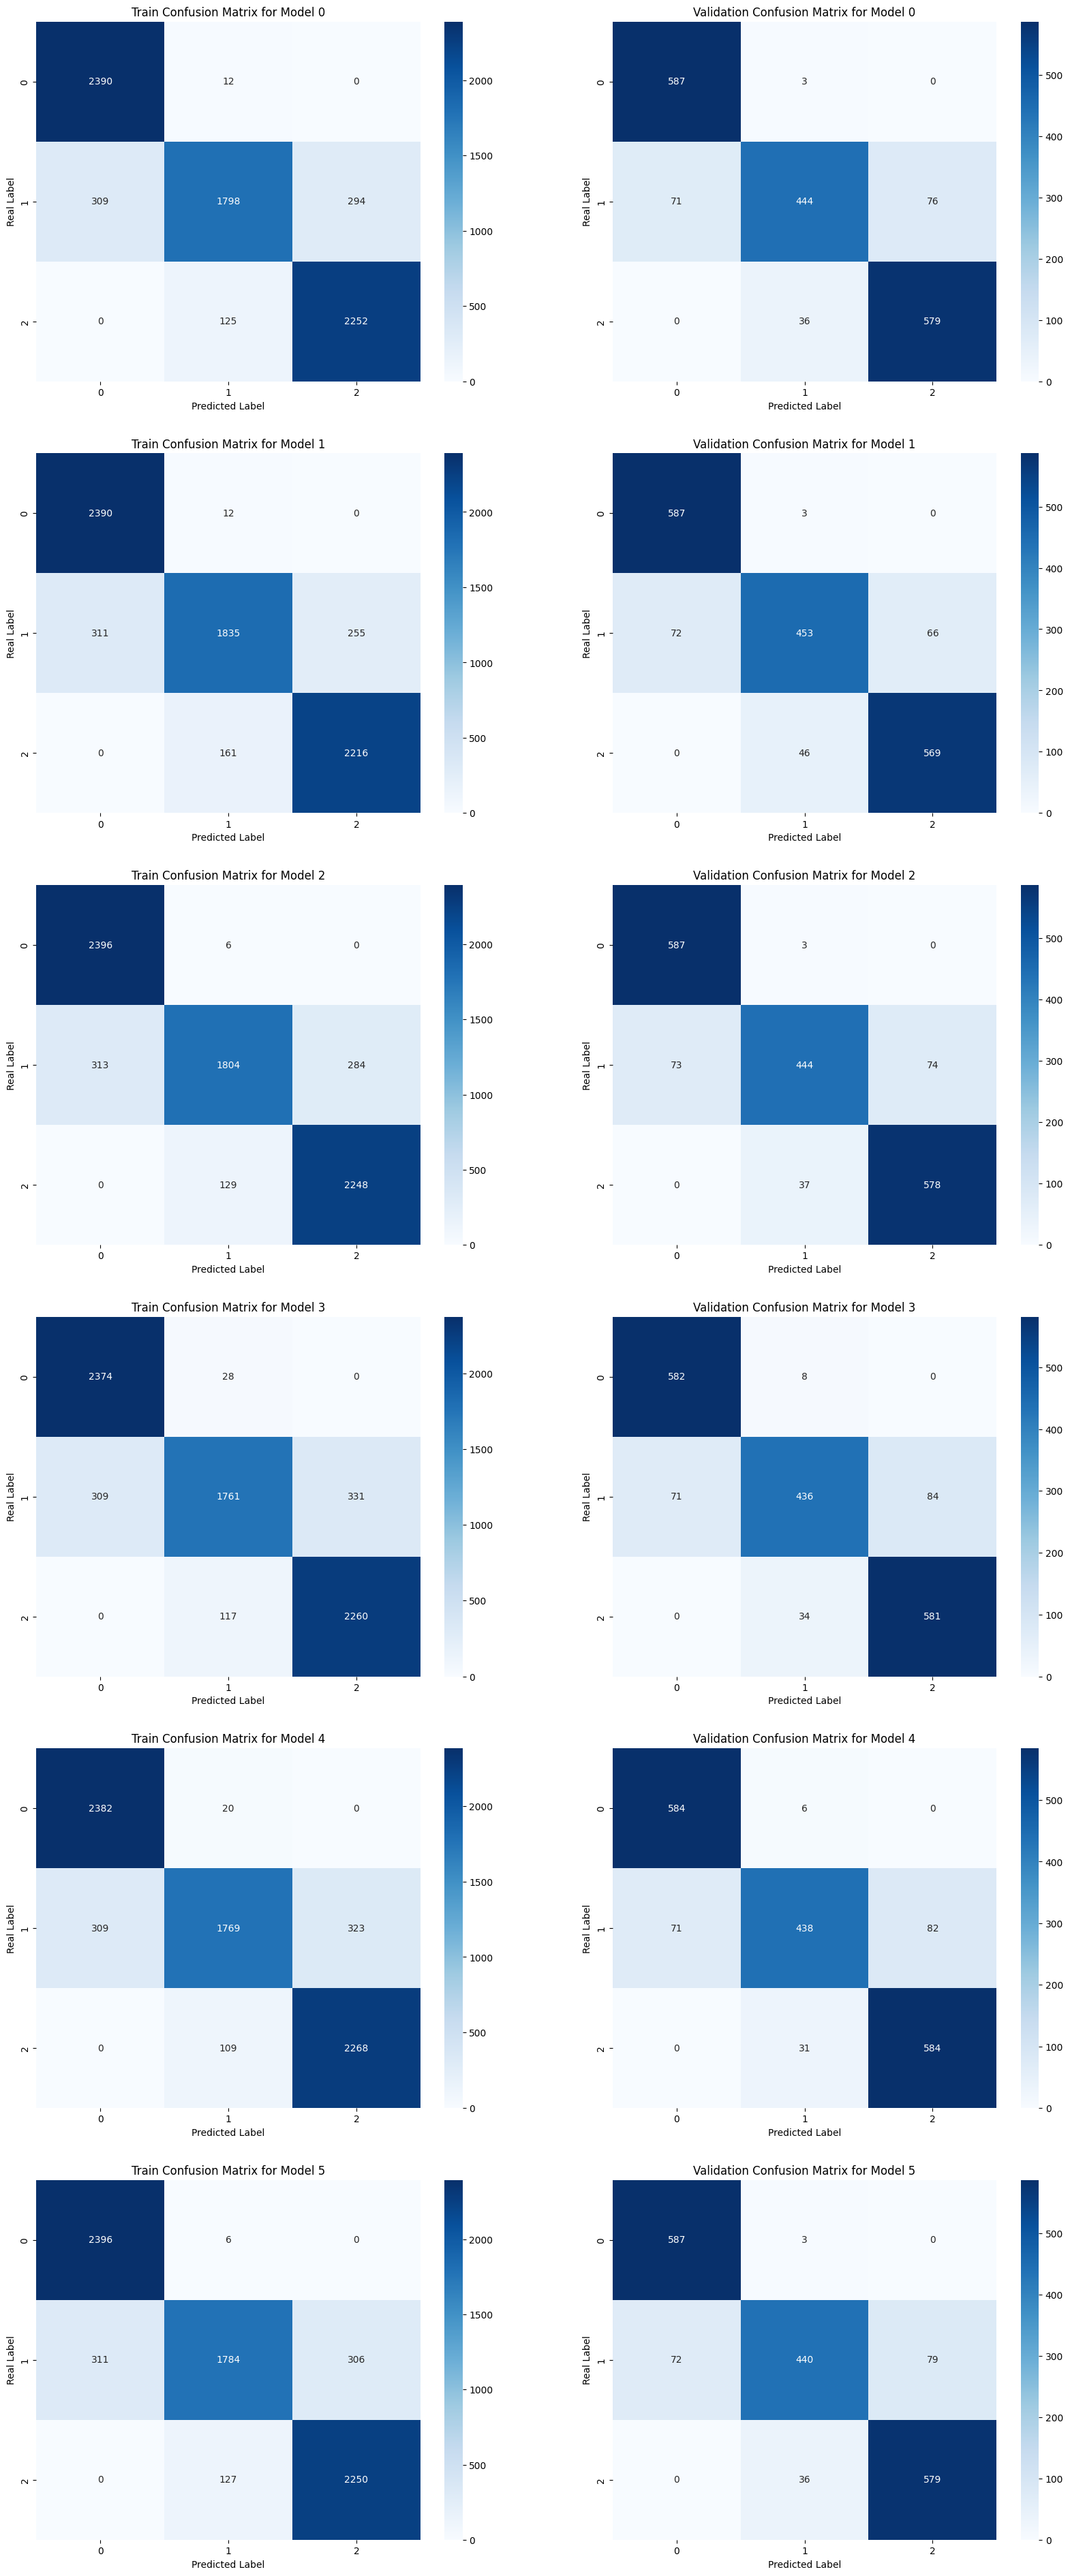

In [27]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

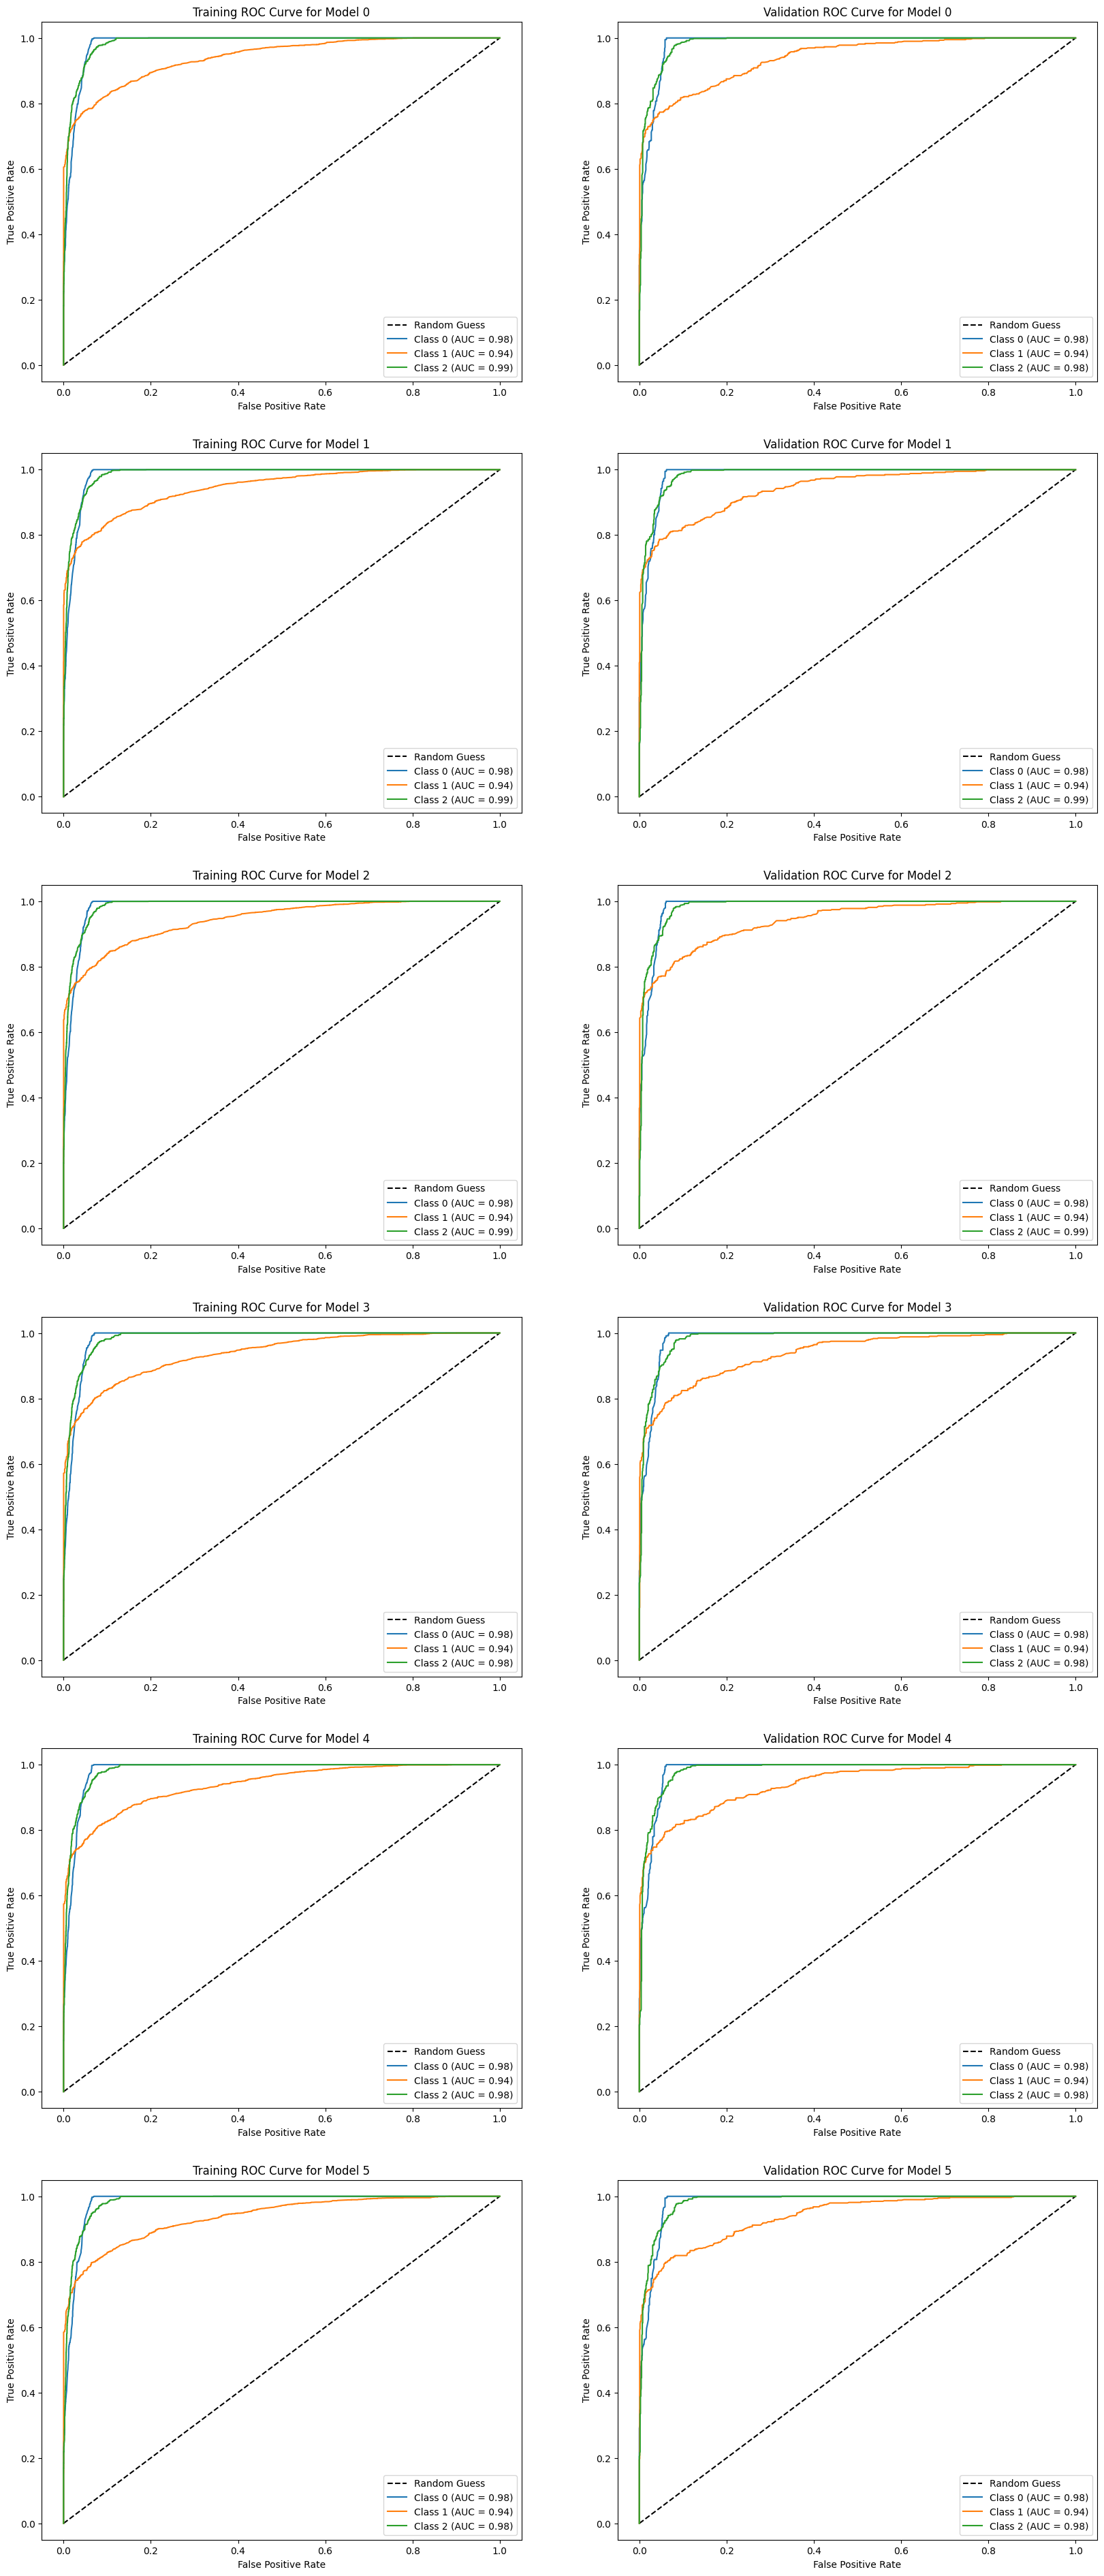

In [28]:
plot_roc_curves(train_roc_curve, val_roc_curve)

In [29]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[0], hyperparameters, device)

Training model 0
Epoch: 0, loss: 0.42466301477588386
Epoch: 1, loss: 0.33503596708837863
Epoch: 2, loss: 0.3239621517405046
Epoch: 3, loss: 0.33036596400547874
Epoch: 4, loss: 0.3018955973397314
Epoch: 5, loss: 0.3099464060722199
Epoch: 6, loss: 0.2961412749986733
Epoch: 7, loss: 0.29177746189906534
Epoch: 8, loss: 0.2871744394697974
Epoch: 9, loss: 0.29530281184521395
Epoch: 10, loss: 0.2897182362796986
Epoch: 11, loss: 0.2955533786948803
Epoch: 12, loss: 0.28339667710582767
Epoch: 13, loss: 0.2866943224077731
Epoch: 14, loss: 0.3042668423293966
Epoch: 15, loss: 0.2979875901895287
Epoch: 16, loss: 0.29201125531597477
Epoch: 17, loss: 0.27704151700028273
Epoch: 18, loss: 0.28712857310223366
Epoch: 19, loss: 0.2799027032029312
Epoch: 20, loss: 0.28060266243673004
Epoch: 21, loss: 0.28198445449888176
Epoch: 22, loss: 0.27835848531891816
Epoch: 23, loss: 0.2986281795048081
Epoch: 24, loss: 0.2734694319356859
Epoch: 25, loss: 0.27192944004736114
Epoch: 26, loss: 0.28294419332415655
Epoch: 

In [30]:
hyperparameters_results = pd.DataFrame({"models": [architectures[0]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.896240,0.896240,0.896240,0.896240,0.896993,0.896993,0.896993,0.896993
1,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.891783,0.891783,0.891783,0.891783,0.893096,0.893096,0.893096,0.893096
2,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.896936,0.896936,0.896936,0.896936,0.895880,0.895880,0.895880,0.895880
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.898607,0.898607,0.898607,0.898607,0.894209,0.894209,0.894209,0.894209
4,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.894568,0.894568,0.894568,0.894568,0.894209,0.894209,0.894209,0.894209
5,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.890390,0.890390,0.890390,0.890390,0.890312,0.890312,0.890312,0.890312
6,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.862535,0.862535,0.862535,0.862535,0.856904,0.856904,0.856904,0.856904
7,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.847493,0.847493,0.847493,0.847493,0.848552,0.848552,0.848552,0.848552


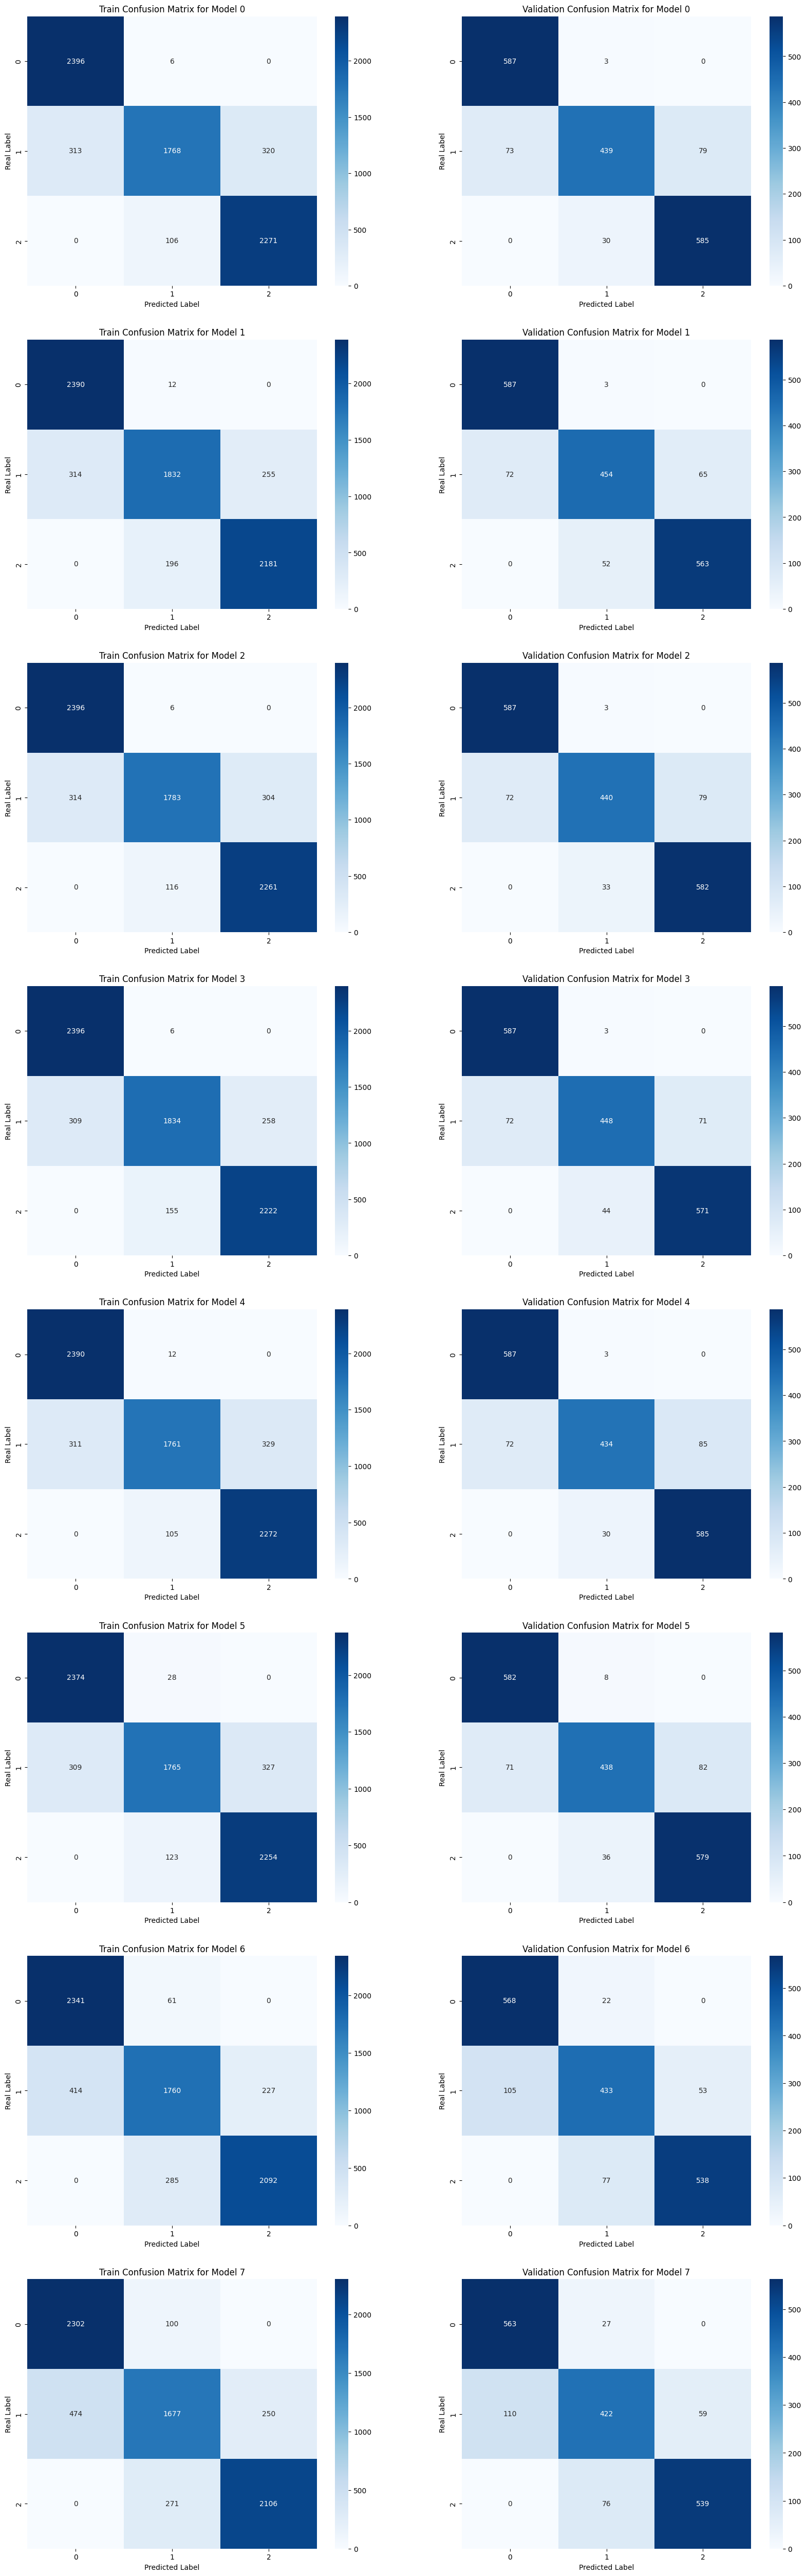

In [31]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

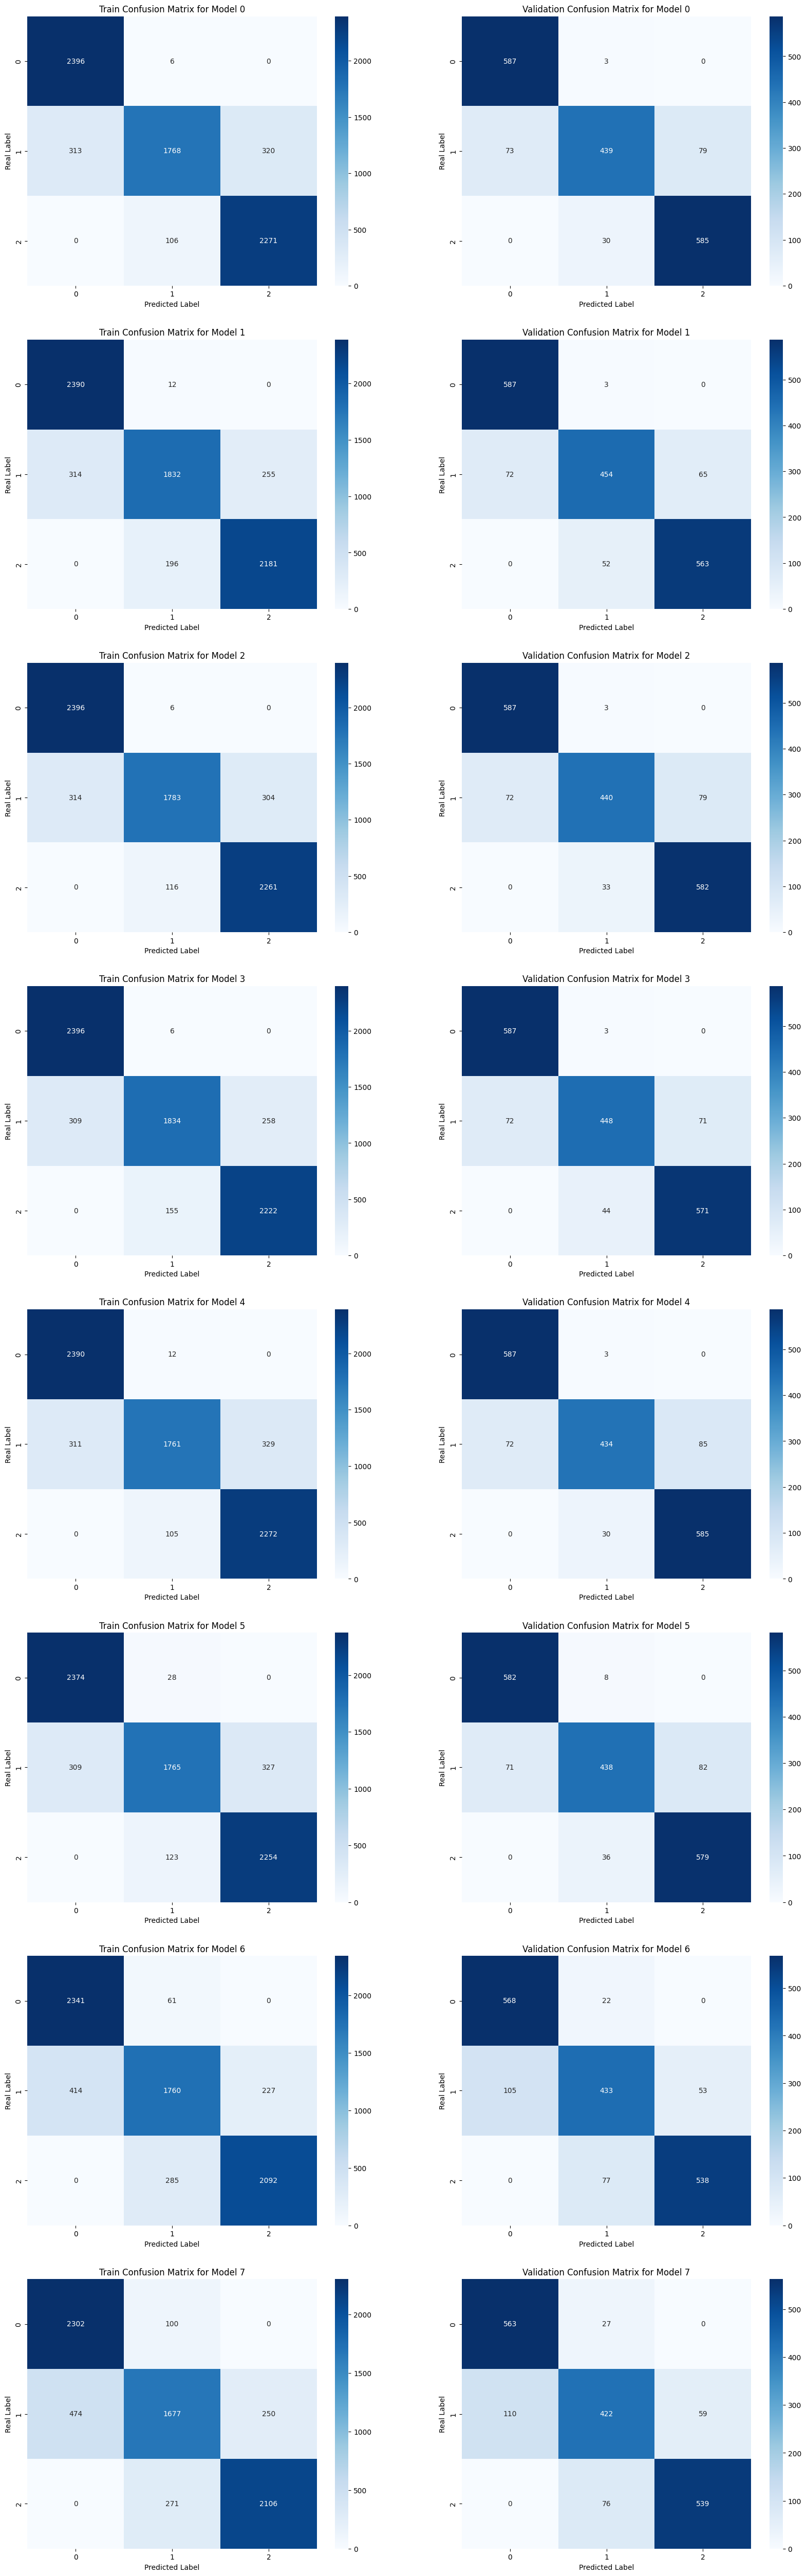

In [ ]:
plot_roc_curves(train_roc_curve, val_roc_curve)

# Predict on test data

In [33]:
final_model = train_final_model(train_x, train_y, architectures[0], hyperparameters[5], device)

Training final model
Epoch: 0, loss: 0.8727909431122897
Epoch: 1, loss: 0.632332956581785
Epoch: 2, loss: 0.5441725541625106
Epoch: 3, loss: 0.5038630308812124
Epoch: 4, loss: 0.4741000527875465
Epoch: 5, loss: 0.4497906492467512
Epoch: 6, loss: 0.44216638646627726
Epoch: 7, loss: 0.41928714252354804
Epoch: 8, loss: 0.40792127973154974
Epoch: 9, loss: 0.39891455100293743
Epoch: 10, loss: 0.3836129095993544
Epoch: 11, loss: 0.3782924335253866
Epoch: 12, loss: 0.365238477786382
Epoch: 13, loss: 0.35798967459745573
Epoch: 14, loss: 0.35373018237582426
Epoch: 15, loss: 0.346571714470261
Epoch: 16, loss: 0.3421911422097892
Epoch: 17, loss: 0.3316280996067482
Epoch: 18, loss: 0.3356872650614956
Epoch: 19, loss: 0.32992496380680486
Epoch: 20, loss: 0.33198719144913186
Epoch: 21, loss: 0.32372807698291645
Epoch: 22, loss: 0.3105472266151194
Epoch: 23, loss: 0.3156549101858808
Epoch: 24, loss: 0.30688345406139106
Epoch: 25, loss: 0.3092732706613708
Epoch: 26, loss: 0.30987369177634255
Epoch: 27

In [34]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns, y=pd.Series(), oversample=False, undersample=False, random_state=42, echo_ordinal_counts=False)

In [35]:
test_preds = predict(final_model, test_x)
np.savetxt("preds.csv", test_preds, delimiter=",", fmt='%d')

# Conclusions